<a href="https://colab.research.google.com/github/kvamleik/NLP-project/blob/main/Text_Classification_EasyJet_Attribute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import pandas as pd

Using TensorFlow backend.


In [ ]:
#Load the dataset

df = pd.read_csv("/Users/martinkvammen/Google Drive (nikolaj.theill@gmail.com)/1. Masters Thesis/5. Shared Thesis /3.1. Data/1. Data processing /Preprocessed data/preprocessed_2000_easyjet.csv")


In [ ]:
col = ['Date', 'Country', 'Processed', 'Attribute']
df = df[col]
df = df[pd.notnull(df['Processed'])]
df = df[pd.notnull(df['Date'])]
df = df[pd.notnull(df['Country'])]
df = df[pd.notnull(df['Attribute'])]


df.head()

,Date,Country,Processed,Attribute
0,06-Aug-2019 11:41PM,France,"['mattiasharri', 'easyjet', 'beat', 'ryanair',...",P
1,03-Aug-2019 01:24AM,United Kingdom,"['pluto_o', 'davewalker_jsi', 'easyjet', 'easy...",P
2,13-Aug-2019 01:13PM,United States,"['anniedressn', 'easyjet', 'wonã', 'email', 'y...",P
3,06-Aug-2019 05:45PM,United Kingdom,"['abditv', 'megangfarm', 'flylo', 'owner', 'om...",P
4,07-Aug-2019 08:55AM,Unknown,"['mattiasharri', 'easyjet', 'beat', 'ryanair',...",P


In [ ]:
df['attribute_id'] = df['Attribute'].factorize()[0]
attribute_id_df = df[['Attribute', 'attribute_id']].drop_duplicates().sort_values('attribute_id')
attribute_to_id = dict(attribute_id_df.values)
id_to_attribute = dict(attribute_id_df[['attribute_id', 'Attribute']].values)


df.head()

,Date,Country,Processed,Attribute,attribute_id
0,06-Aug-2019 11:41PM,France,"['mattiasharri', 'easyjet', 'beat', 'ryanair',...",P,0
1,03-Aug-2019 01:24AM,United Kingdom,"['pluto_o', 'davewalker_jsi', 'easyjet', 'easy...",P,0
2,13-Aug-2019 01:13PM,United States,"['anniedressn', 'easyjet', 'wonã', 'email', 'y...",P,0
3,06-Aug-2019 05:45PM,United Kingdom,"['abditv', 'megangfarm', 'flylo', 'owner', 'om...",P,0
4,07-Aug-2019 08:55AM,Unknown,"['mattiasharri', 'easyjet', 'beat', 'ryanair',...",P,0


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
df.groupby('Attribute').Processed.count().plot.bar(ylim=0)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))

features_attribute = tfidf.fit_transform(df.Processed).toarray()
labels = df.attribute_id
features_attribute.shape

(1746, 692)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Attribute, attribute_id in sorted(attribute_to_id.items()):
  features_chi2 = chi2(features_attribute, labels == attribute_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Attribute))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'NP':
  . Most correlated unigrams:
. luton
. beat
  . Most correlated bigrams:
. easyjet beat
. geneva allow
# 'P':
  . Most correlated unigrams:
. luton
. beat
  . Most correlated bigrams:
. easyjet beat
. geneva allow


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Processed'], df['Attribute'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [ ]:
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, multi_class='multinomial'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features_attribute, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

/Users/nikolajfrandsen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nikolajfrandsen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: Solver liblinear does not support a multinomial backend.

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.807610
LogisticRegression        0.812178
MultinomialNB             0.814484
RandomForestClassifier    0.804169
Name: accuracy, dtype: float64

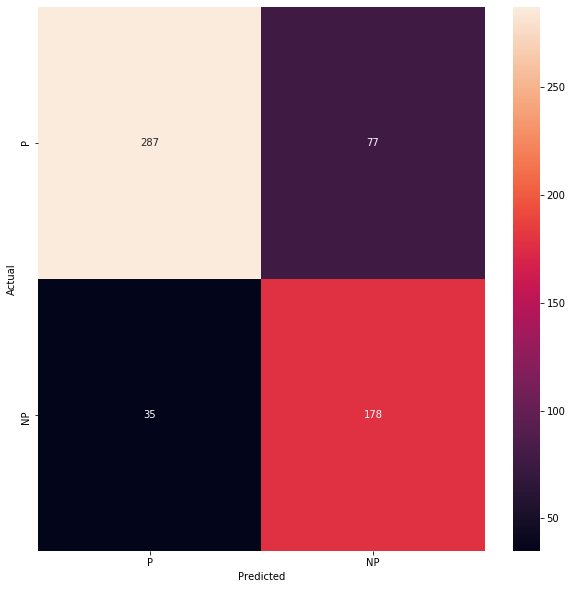

In [ ]:
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features_attribute, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=attribute_id_df.Attribute.values, yticklabels=attribute_id_df.Attribute.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model.fit(features_attribute, labels)
N = 5
for Attribute, attribute_id in sorted(attribute_to_id.items()):
  indices = np.argsort(model.coef_[attribute_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Attribute))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Attribute'].unique()))

In [ ]:
easyjet = pd.read_csv("/Users/martinkvammen/Google Drive (nikolaj.theill@gmail.com)/1. Masters Thesis/5. Shared Thesis /3.1. Data/1. Data processing /Preprocessed data/preprocessed_original_easyjet.csv")
ej = ['Date', 'Country', 'Processed']


In [ ]:
easyjet = easyjet[ej]

easyjet = easyjet[pd.notnull(easyjet['Processed'])]
easyjet = easyjet[pd.notnull(easyjet['Date'])]
easyjet = easyjet[pd.notnull(easyjet['Country'])]

easyjet.count()

Date         89544
Country      89544
Processed    89544
dtype: int64

In [ ]:
X_new_tfidf = tfidf.transform(easyjet.Processed)

In [ ]:
predictions = model.predict(X_new_tfidf)

In [ ]:
easyjet['Attribute Predicted'] = predictions

In [ ]:
easyjet.tail(20)

,Date,Country,Processed,Attribute Predicted
89524,31-Jul-2019 12:44PM,Unknown,"['easyjet', 'know', 'offer', 'flight', 'week',...",1
89525,31-Jul-2019 12:45PM,United Kingdom,"['cloudsurferdom', 'easyjet', 'airbus', 'schip...",1
89526,31-Jul-2019 12:45PM,United Kingdom,"['keatonrobot', 'easyjet', 'taxi', 'miss', 'ai...",1
89527,31-Jul-2019 12:45PM,United Kingdom,"['caroleadov', 'nathalie_robin', 'easyjet', 'n...",1
89528,31-Jul-2019 12:46AM,Unknown,"['easyjet', 'jam']",0
89529,31-Jul-2019 12:46PM,Unknown,"['cloudsurferdom', 'easyjet', 'airbus', 'schip...",1
89530,31-Jul-2019 12:47PM,Unknown,"['xr_cambridg', 'easyjet']",0
89531,31-Jul-2019 12:48AM,Germany,"['easyjet', 'disappoint', 'flight']",0
89532,31-Jul-2019 12:49PM,Indonesia,"['globetrotg', 'fli', 'pragu', 'easyjet', 'bus...",1
89533,31-Jul-2019 12:50AM,France,"['lizzyjburn', 'easyjet', 'miss', 'connect', '...",1


In [ ]:
easyjet.to_csv('/Users/nikolajfrandsen/Google Drive (nikolaj.theill@gmail.com)/1. Masters Thesis/5. Shared Thesis /3.1. Data/2. Analytics/EasyJet_TextClassification/predicted/EasyJet_Attribute_Test.csv')